In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sqlalchemy import create_engine
import geopandas as gpd
import seaborn as sns
import matplotlib as plt

In [2]:
#Precincts
conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset={encoding}'.format(
    user='student', 
    password='dwdstudent2015', 
    host = 'db.ipeirotis.org', 
    port=3306, 
    db='public',
    encoding = 'utf8'
)
enginePrec = create_engine(conn_string)

In [3]:
df_prec = pd.read_sql ("select * from dwd_2019_group_d_nyc_precincts where Borough = 'Manhattan';", con = enginePrec, coerce_float = True)
df_prec['Latitude'] = pd.to_numeric(df_prec['Latitude'])
df_prec['Longitude'] = pd.to_numeric(df_prec['Longitude'])


In [4]:
conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset={encoding}'.format(
    user='student', 
    password='dwdstudent2015', 
    host = 'db.ipeirotis.org', 
    port=3306, 
    db='nypd_complaints',
    encoding = 'utf8'
)
engine = create_engine(conn_string)

In [5]:


query = '''
select Latitude, Longitude, dayofweek(CMPLNT_FR) as dy, hour(CMPLNT_FR) as hr, OFNS_DESC,
count(distinct(CMPLNT_NUM)) as CmplNum
from nypd
where OFNS_DESC in (
	'GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 
    'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE', 
    'MURDER & NON-NEGL. MANSLAUGHTER'
)
and YEAR(CMPLNT_FR) > 2005 and YEAR(CMPLNT_FR) < 2017 and LAW_CAT_CD = 'FELONY'
and BORO_NM = 'MANHATTAN' and Latitude is not null
group by Latitude, Longitude, dy, hr, OFNS_DESC;
'''
df = pd.read_sql(query, con = engine)


In [6]:
df = df.set_index(['Latitude', 'Longitude'])


In [7]:
df_pvt = pd.pivot_table(df, index = ['Latitude', 'Longitude'], values = 'CmplNum', columns = 'OFNS_DESC', aggfunc = 'sum')
df_pvt = df_pvt.reset_index()

In [8]:
#Nearest Neighbors - Map Each Compalint point to nearest precinct
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
#Mapping Function
def nearest(row, geom_union, df1, df2, geom1_col='geometry', geom2_col='geometry', src_column=None):
    """Find the nearest point and return the corresponding value from specified column."""
    # Find the geometry that is closest
    nearest = df2[geom2_col] == nearest_points(row[geom1_col], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    value = df2[nearest][src_column].get_values()[0]
    return value

In [9]:
dfg_prec = gpd.GeoDataFrame(
    df_prec, geometry=gpd.points_from_xy(df_prec.Longitude, df_prec.Latitude))
dfg_pvt = gpd.GeoDataFrame(
    df_pvt, geometry=gpd.points_from_xy(df_pvt.Longitude, df_pvt.Latitude))

unary_union = dfg_prec.unary_union

In [10]:
#Try Skipping - May Not be needed
dfg_pvt['centroid']= dfg_pvt.centroid 
dfg_prec['centroid'] = dfg_prec.centroid #May not be needed

In [11]:
#dfg_prec.head()
#dfg_pvt =dfg_pvt.set_index(['Latitude', 	'Longitude'])
#dfg_prec = dfg_prec.set_index(['Latitude', 	'Longitude'])

dfg_pvt = dfg_pvt.reset_index()
dfg_prec = dfg_prec.reset_index()


In [12]:
#Execute Function to map every complaint to Nearest Precinct
dfg_pvt['NearestPrec'] = dfg_pvt.apply(nearest, geom_union=unary_union, df1=dfg_pvt, df2=dfg_prec, geom1_col='centroid', src_column='Precinct', axis=1)

In [13]:
#Totals for Relative Graphs
df_precTotals = dfg_pvt.groupby(['NearestPrec']).sum()[['GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 
    'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE', 
    'MURDER & NON-NEGL. MANSLAUGHTER']]

In [14]:
df_precTotals.head(2) #Check index and totals

OFNS_DESC,GRAND LARCENY,ROBBERY,FELONY ASSAULT,BURGLARY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON-NEGL. MANSLAUGHTER
NearestPrec,,,,,,
10th Precinct,12863.0,1857.0,1374.0,2278.0,515.0,19.0
13th Precinct,15541.0,1975.0,1673.0,2839.0,622.0,16.0


10th_Precinct.svg
13th_Precinct.svg
17th_Precinct.svg
19th_Precinct.svg
1st_Precinct.svg
20th_Precinct.svg
23rd_Precinct.svg
24th_Precinct.svg
25th_Precinct.svg
26th_Precinct.svg
28th_Precinct.svg
30th_Precinct.svg
32nd_Precinct.svg
33rd_Precinct.svg
34th_Precinct.svg
5th_Precinct.svg
6th_Precinct.svg
7th_Precinct.svg
9th_Precinct.svg
Central_Park_Precinct.svg
Midtown_North_Precinct.svg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


Midtown_South_Precinct.svg


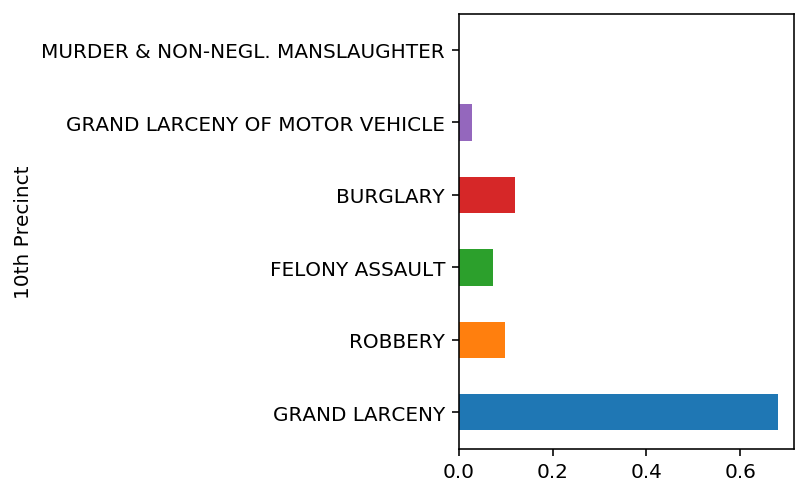

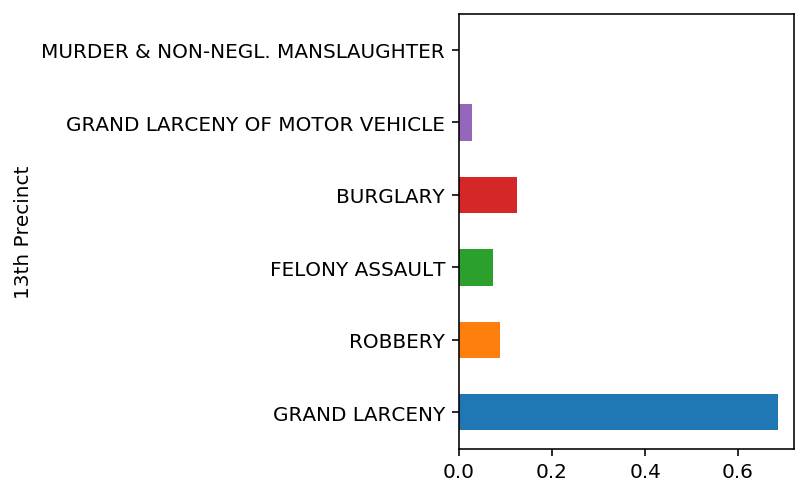

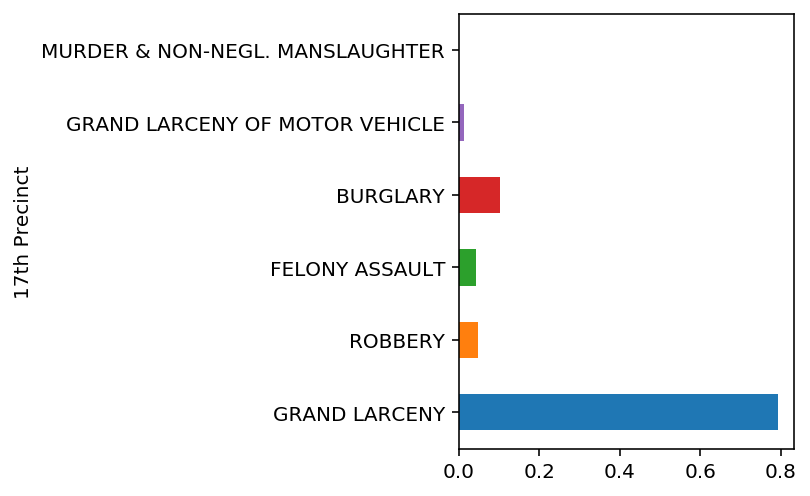

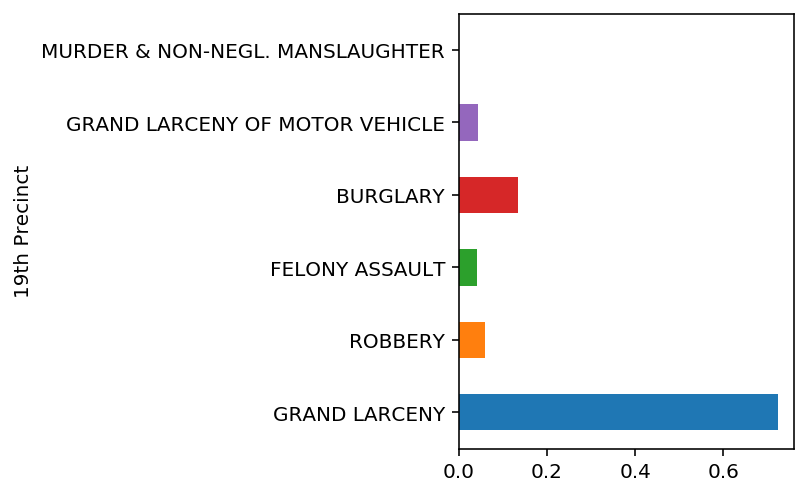

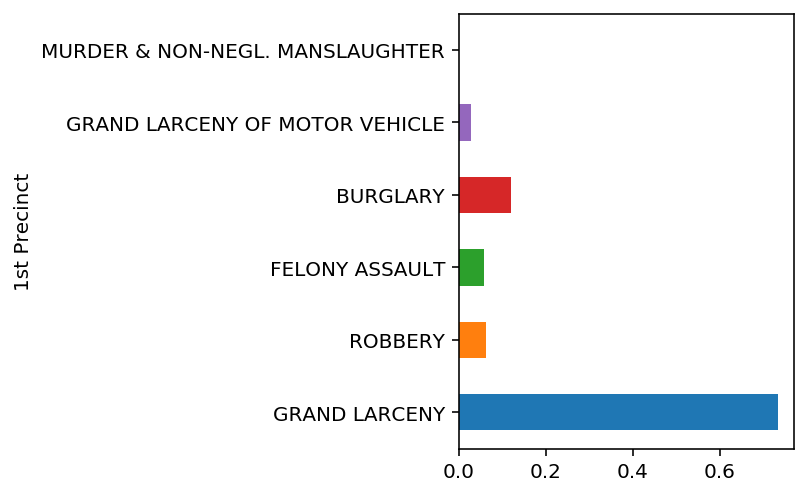

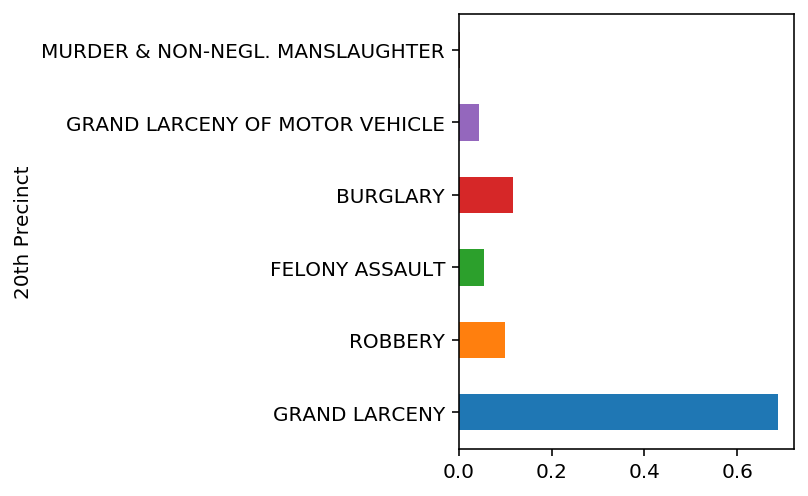

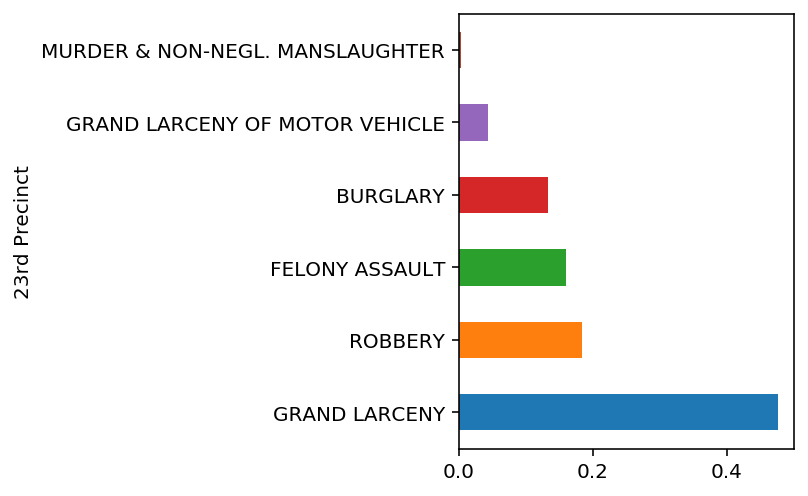

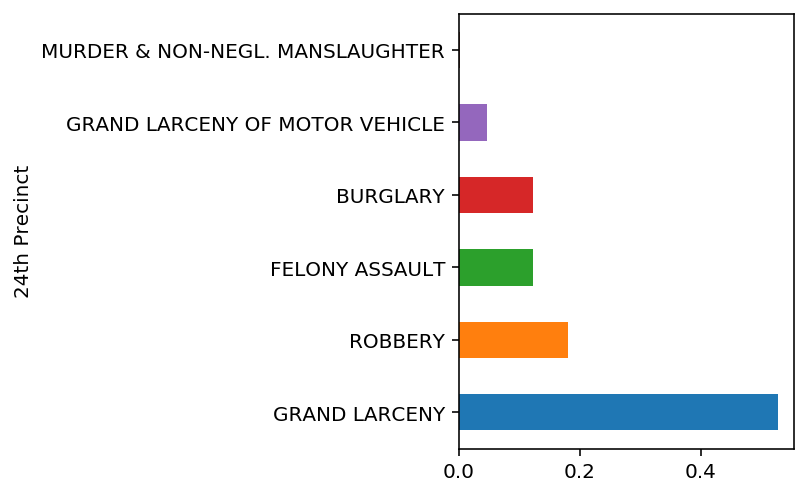

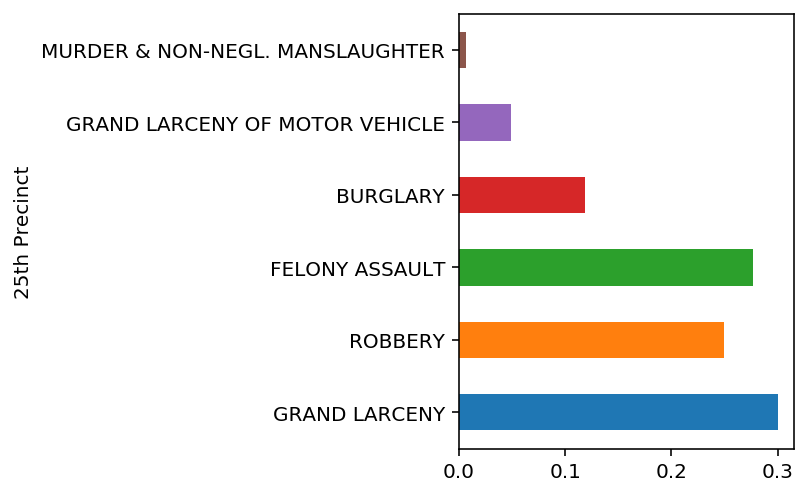

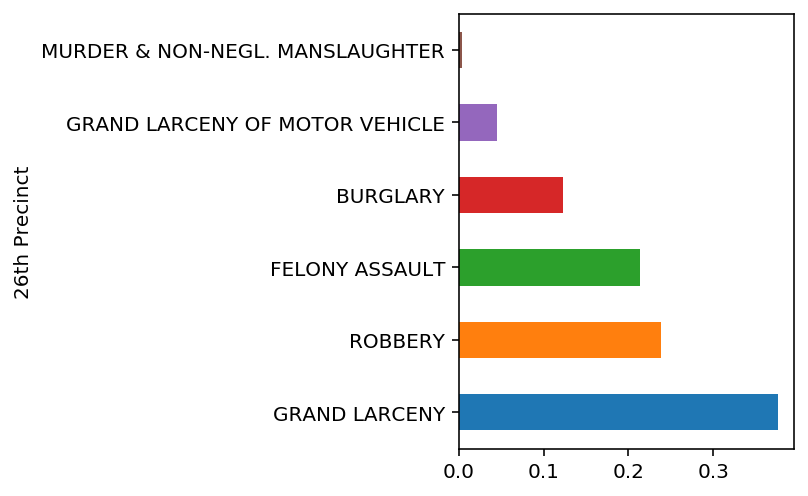

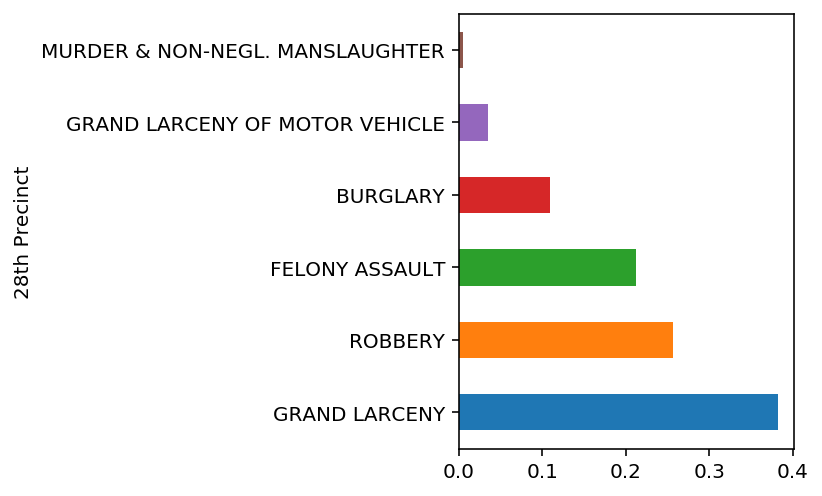

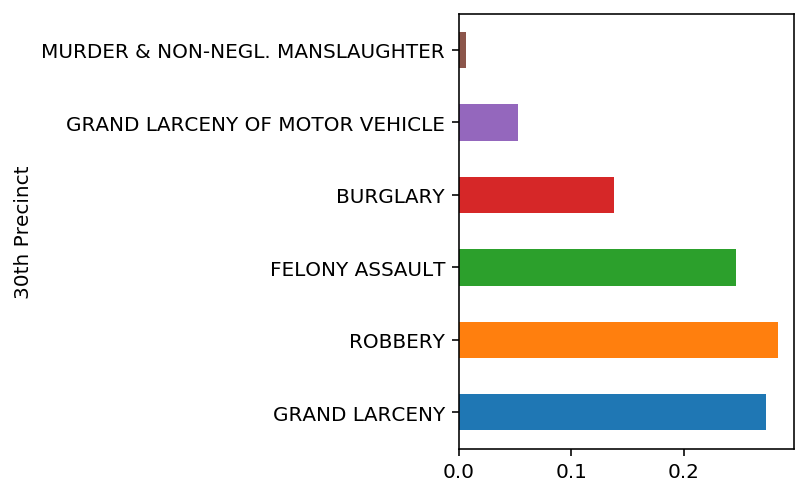

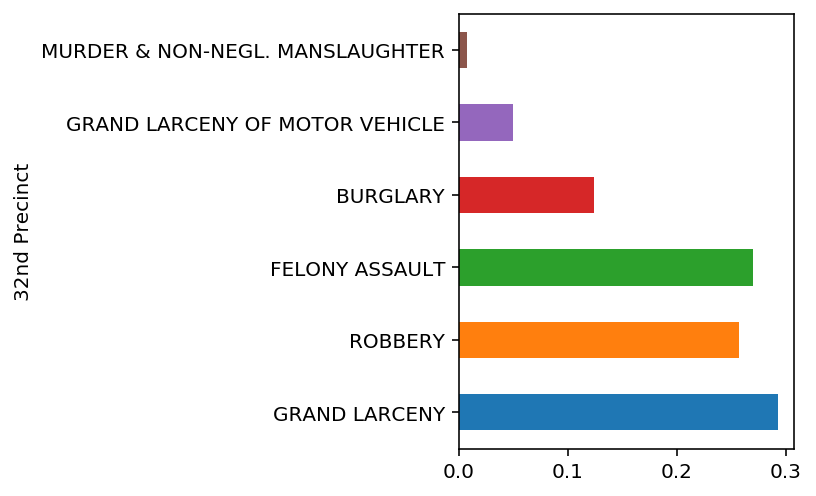

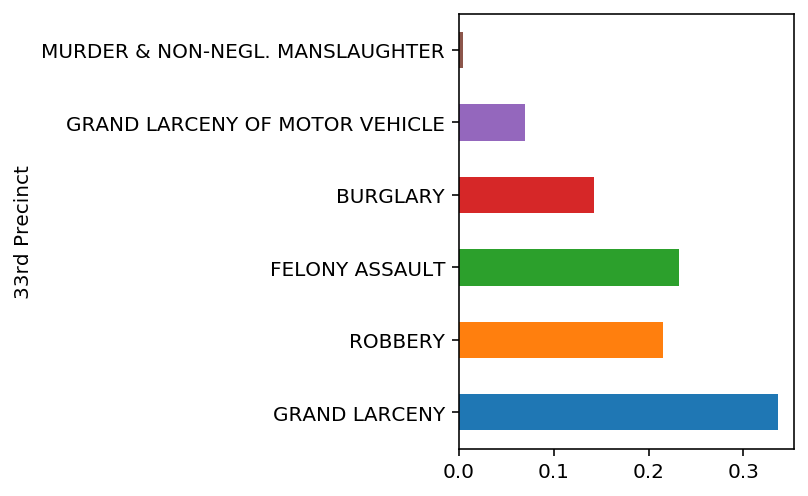

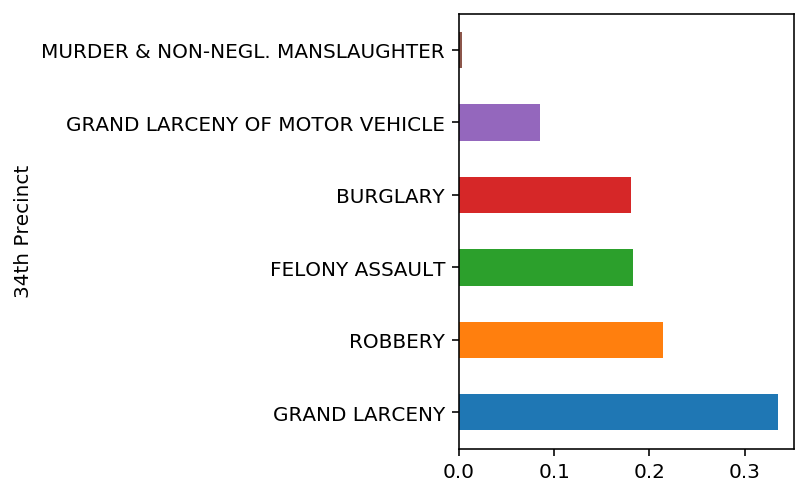

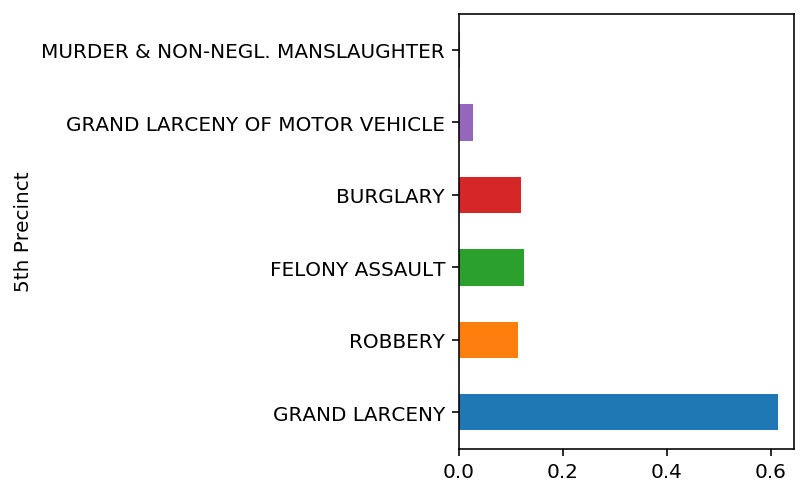

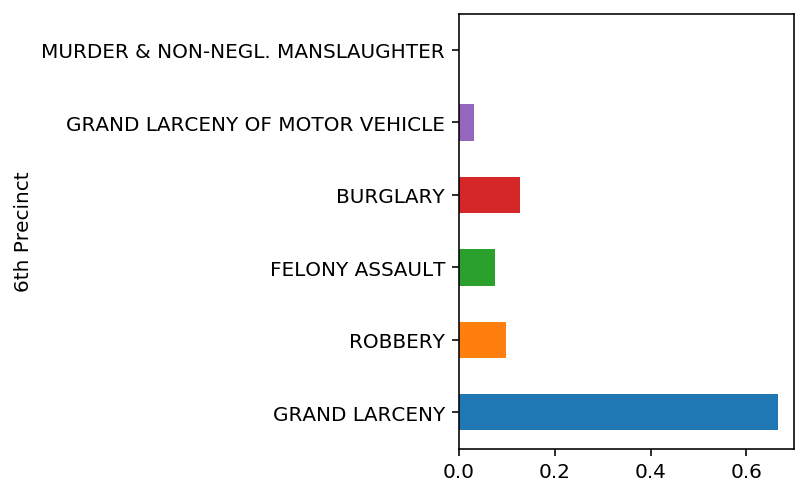

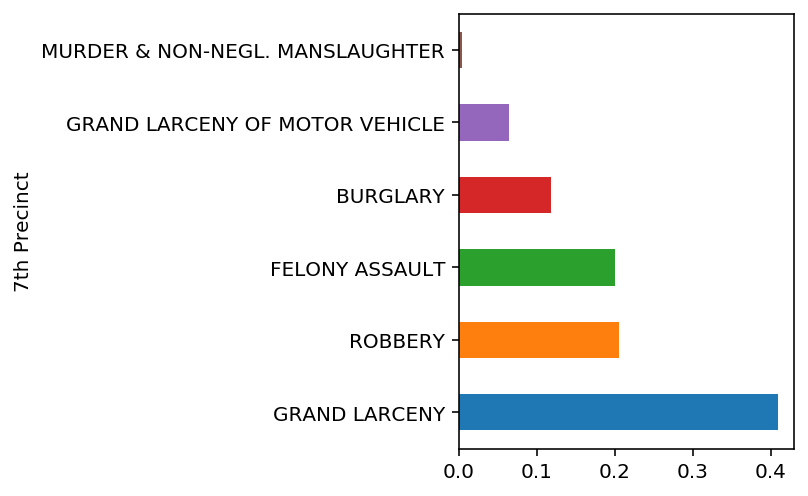

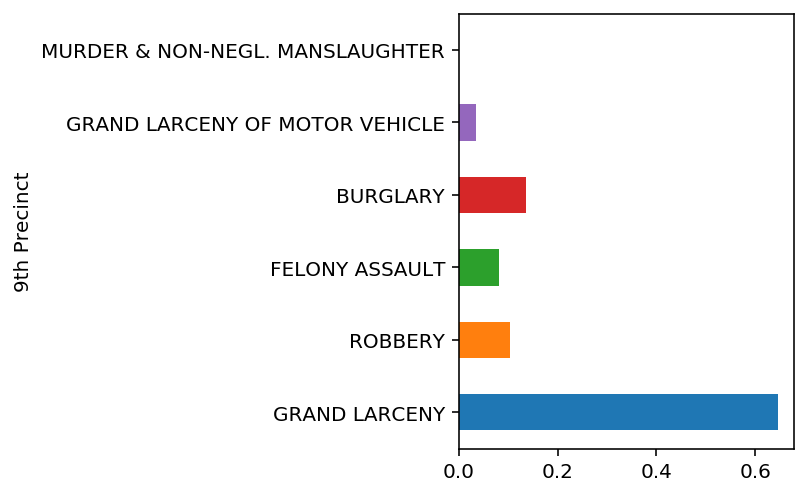

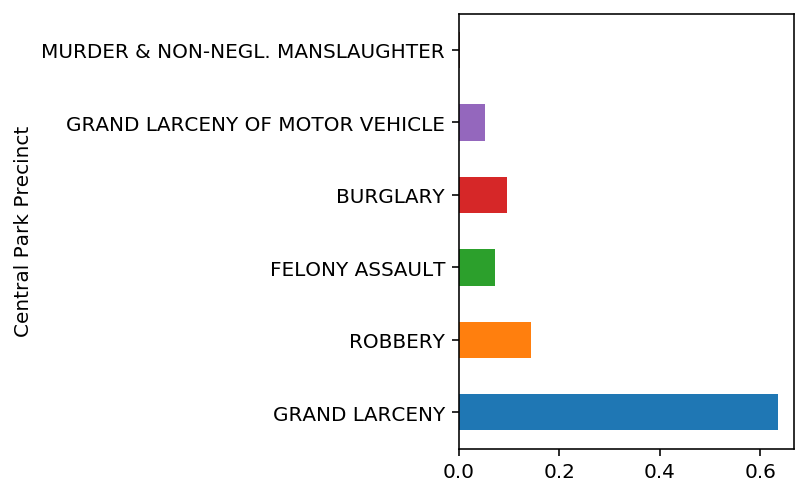

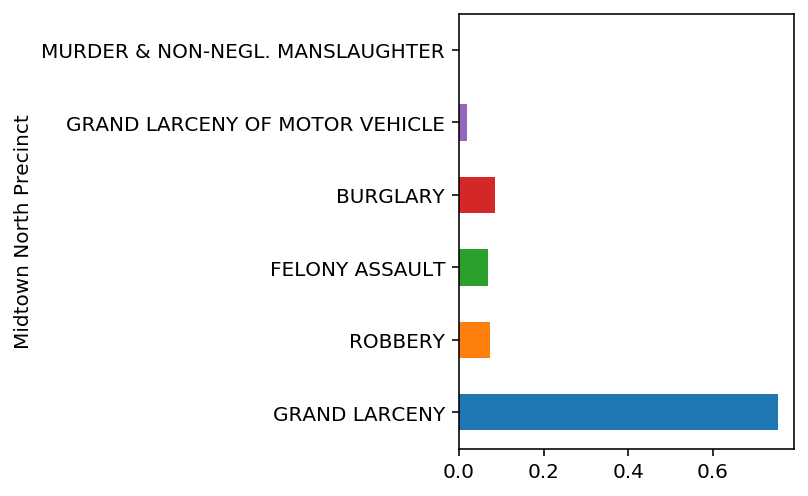

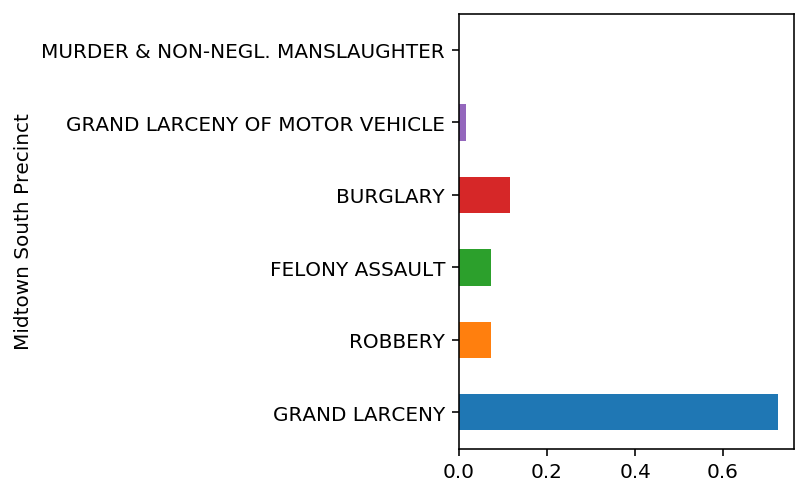

In [15]:
#Generate and Save Graphs
#df_precTotals set index to Precinct column
#Generate Graphs and save for 
#Saving Figures!:
import base64
import matplotlib.pyplot as plt

for idx, row in df_precTotals.iterrows():
  tmp = (row/(df_precTotals.sum(axis = 1)[str(idx)]))
  fig, ax = plt.subplots(figsize= (3, 4))
  ax = tmp.plot(kind = "barh")
  ax.set_ylabel(str(idx))
  #nme = str(idx).replace(" ", "_") + ".png"
  #Switching to svg because can't parse and show png for some reason
  nme = str(idx).replace(" ", "_") + ".svg"
  print(nme)
  fig.savefig(nme, dpi = 75)

In [16]:
!pip3 install folium
!pip3 install geopy


In [17]:
from folium.plugins import HeatMap

In [18]:
import folium
from folium import IFrame 
resolution = 75
width = 6
height = 8

In [33]:
folium_map = folium.Map(location =[40.78, -73.98], zoom_start = 12 )

In [34]:
for idx, row in df_prec.iterrows():
  #png = row['Precinct'].replace(" ", "_") + ".png"
  #Swithcing to svg
  svg = row['Precinct'].replace(" ", "_") + ".svg"
#  encoded = base64.b64encode(open(png, 'rb').read())
#  html = '<img src="data:image/png;base64,{}">'.format(png)
#  html = '<img src="data:image/png;,{}">'.format
  print(svg)
  tmp = str(open(svg).read())
  svg = "<svg" + tmp.split("<svg",1)[1]

  
#  iframe = IFrame(html(png), width=(width*resolution)+20, height=(height*resolution)+20)
  iframe = IFrame(svg, width=(width*resolution)+20, height=(height*resolution)+20)
  popup = folium.Popup(iframe, max_width=1200)

  #marker = folium.Circle(location = [40.72,-74.0], tooltip = "Test", popup = "Graph Here", color='#3186cc', fill=True, fill_color='#3186cc', radius = 200)
  marker = folium.Circle(location = [row['Latitude'], row['Longitude']], tooltip = row['Precinct'], popup = popup, color='red', ##3186cc
    fill=True,
    fill_color='#3186cc',
    radius = 500)
  marker.add_to(folium_map)
  

1st_Precinct.svg
5th_Precinct.svg
6th_Precinct.svg
7th_Precinct.svg
9th_Precinct.svg
10th_Precinct.svg
13th_Precinct.svg
Midtown_South_Precinct.svg
17th_Precinct.svg
Midtown_North_Precinct.svg
19th_Precinct.svg
20th_Precinct.svg
Central_Park_Precinct.svg
23rd_Precinct.svg
24th_Precinct.svg
25th_Precinct.svg
26th_Precinct.svg
28th_Precinct.svg
30th_Precinct.svg
32nd_Precinct.svg
33rd_Precinct.svg
34th_Precinct.svg


In [ ]:
#from folium.plugins import HeatMapWithTime
#https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf

In [21]:
#Data Grab for Moving HeatMap MODIFY ORIGINAL QUERY FOR THE BIG 7?
query = '''
select Latitude, Longitude, count(distinct(CMPLNT_NUM)) as CmplNum, CMPLNT_FR as CmplDte, OFNS_DESC from nypd
where OFNS_DESC in (
	'GRAND LARCENY', 'ROBBERY', 'FELONY ASSAULT', 
    'BURGLARY', 'GRAND LARCENY OF MOTOR VEHICLE', 
    'MURDER & NON-NEGL. MANSLAUGHTER'
)
and YEAR(CMPLNT_FR) > 2005 and YEAR(CMPLNT_FR) < 2017 and LAW_CAT_CD = 'FELONY' and BORO_NM = 'MANHATTAN'
group by Latitude, Longitude, CmplDte, OFNS_DESC;
'''
df_hr = pd.read_sql(query, con = engine)
df_hr.CmplDte = pd.to_datetime(df_hr.CmplDte, format="%Y-%m-%d")


df_hr['HOUR'] = df_hr.CmplDte.dt.hour
dfhrp = pd.pivot_table(df_hr, index = ['HOUR','Latitude', 'Longitude'], values = 'CmplNum', columns = 'OFNS_DESC', aggfunc = 'sum') 


In [22]:
dfhrp.reset_index()['Latitude'].head() #Check

0    40.701489
1    40.701541
2    40.701557
3    40.701667
4    40.701791
Name: Latitude, dtype: float64

In [23]:
dfhrp= dfhrp.reset_index()

In [24]:
dfhrp.head().sum(axis=1)

0   -30.311056
1   -31.310647
2   -32.310764
3   -32.310943
4   -32.309376
dtype: float64

In [25]:
dfhrp['7Crimes'] = dfhrp[['BURGLARY', 	'FELONY ASSAULT',
       'GRAND LARCENY', 	'GRAND LARCENY OF MOTOR VEHICLE', 'MURDER & NON-NEGL. MANSLAUGHTER', 	'ROBBERY']].sum(axis =1)

In [26]:
#MOVING HEATMAP --- but needs to be in layers https://automating-gis-processes.github.io/2018/notebooks/L5/interactive-map-folium.html#Layer-control
from folium.plugins import HeatMapWithTime

In [27]:
#Just general crime for now
dfhrp[['HOUR','Latitude', 'Longitude',  '7Crimes']].head()

OFNS_DESC,HOUR,Latitude,Longitude,7Crimes
0,0,40.701489,-74.012545,3.0
1,0,40.701541,-74.012188,2.0
2,0,40.701557,-74.012321,1.0
3,0,40.701667,-74.012610,1.0
4,0,40.701791,-74.011167,1.0


In [35]:
#Try layers
from folium.plugins import HeatMapWithTime


for crime in ['BURGLARY', 	'FELONY ASSAULT', 'GRAND LARCENY', 	'GRAND LARCENY OF MOTOR VEHICLE', 'MURDER & NON-NEGL. MANSLAUGHTER', 	'ROBBERY']:
  dfhrp_list = []
  for hour in dfhrp.HOUR.sort_values().unique():
    dfhrp_list.append(dfhrp.loc[dfhrp.HOUR == hour, ['Latitude', 'Longitude', crime]]
                    .groupby(['Latitude', 'Longitude'])
                    .sum().reset_index().values.tolist())
  hm = HeatMapWithTime(dfhrp_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(folium.FeatureGroup(name=crime))
  folium_map.add_children(hm)
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  if sys.path[0] == '':


In [29]:
#No Layers
if 1 == 0:
    dfhrp_list = []
    for hour in dfhrp.HOUR.sort_values().unique():
        dfhrp_list.append(dfhrp.loc[dfhrp.HOUR == hour, ['Latitude', 'Longitude', '7Crimes']]
                    .groupby(['Latitude', 'Longitude'])
                    .sum().reset_index().values.tolist())

In [36]:
folium.LayerControl().add_to(folium_map)

In [37]:
folium_map.save("CrimeLayers.html")